In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Загрузка данных из CSV-файла
csv_file_path = 'data.csv'
data = pd.read_csv(csv_file_path)

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Разделение данных на признаки и метки
features = data.drop('4', axis=1).values
labels = data['4'].values
labels = LabelEncoder().fit_transform(labels)

In [3]:
# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Пример простого класса Dataset
class IrisDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        sample = self.features[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Пример трансформации для предобработки данных
# В данном случае трансформация не используется, но вы можете добавить ее по необходимости
def transform(sample):
    return sample

# Создание объектов Dataset
train_dataset = IrisDataset(features=X_train, labels=y_train, transform=transform)
test_dataset = IrisDataset(features=X_test, labels=y_test, transform=transform)

# Создание DataLoader для обучающего и тестового наборов
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Теперь вы можете использовать train_loader и test_loader для обучения и тестирования вашей модели

In [4]:
from neural import MLPTorchMultiLayerSigmoid, MLPTorchMultiLayerReLU
from IPython.display import display, clear_output

## Обучение

Гиперпараметры

In [5]:
in_size = 4 # Количество входных признаков
hidden_sizes = [128, 64, 64] # Скрытые слои
out_size = 3 # Количество классов

Модель с сигмоидной активацией

In [6]:
criterion = torch.nn.CrossEntropyLoss()  # В случае классификации
model = MLPTorchMultiLayerSigmoid(in_size, hidden_sizes, out_size)
optimizer1 = optim.Adam(model.parameters(), lr=0.01)

In [7]:
num_epochs = 1000

In [57]:
for epoch in range(num_epochs):
    for inputs, labels in train_loader:  # train_loader - ваш DataLoader для обучения
        # Обнуление градиентов перед каждым батчем
        optimizer1.zero_grad()

        # Прямой проход (вычисление предсказаний модели)
        outputs = model(inputs)

        # Вычисление функции потерь
        loss = criterion(outputs, labels)

        # Обратный проход (распространение градиентов)
        loss.backward()

        # Обновление весов
        optimizer1.step()

    clear_output(wait=True)
    display(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

'Epoch [1000/1000], Loss: 0.6402'

In [8]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer1.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()

        # Вычисление точности на текущем батче
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples

    clear_output(wait=True)
    display(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%')

    # Проверка точности и остановка, если достигнута необходимая точность
    if accuracy >= 0.8:
        print(f'Accuracy reached {accuracy * 100:.2f}%. Stopping training.')
        break

'Epoch [9/1000], Loss: 0.8236, Accuracy: 80.00%'

Accuracy reached 80.00%. Stopping training.


Проверка модели

In [9]:
model.eval()  # Установка модели в режим оценки (выключение dropout и т.д.)

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Выбираем индекс с наибольшим значением

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

Accuracy on the test set: 80.00%


## ROC-анализ

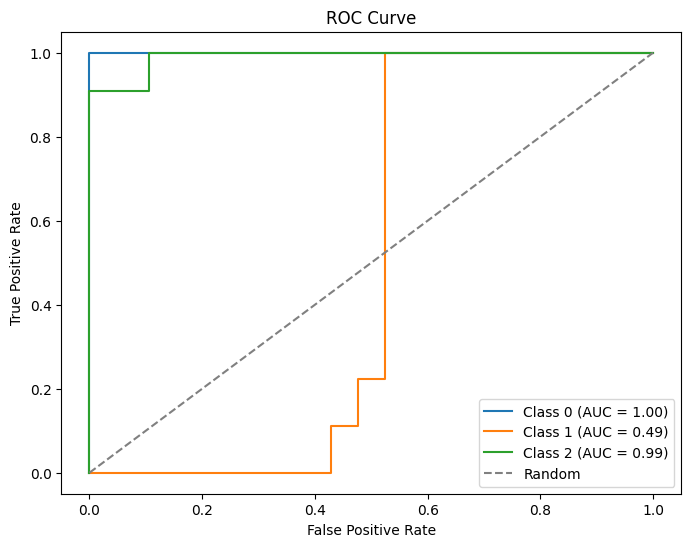

Weighted AUC: 0.83


In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Получение вероятностей принадлежности к каждому классу
model.eval()  # Установка модели в режим оценки
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_probs.extend(outputs.numpy())
        all_labels.extend(labels.numpy())

# Преобразование меток в one-hot encoding формат
all_labels_one_hot = np.eye(out_size)[all_labels]

# Рассчитываем ROC-кривую и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(out_size):
    fpr[i], tpr[i], _ = roc_curve(np.array(all_labels_one_hot)[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Средневзвешенный AUC (если у вас более двух классов)
weighted_auc = np.mean(list(roc_auc.values()))

# Визуализация ROC-кривых
plt.figure(figsize=(8, 6))

for i in range(out_size):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f'Weighted AUC: {weighted_auc:.2f}')

## Матрица неточности

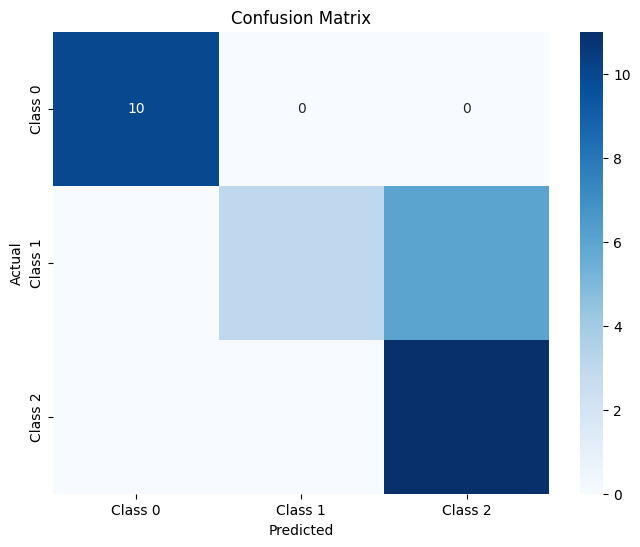

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Получение предсказаний модели на тестовом наборе данных
model.eval()
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.numpy())

# Рассчитываем матрицу неточности
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Визуализация матрицы неточности
class_names = [f'Class {i}' for i in range(out_size)]
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Модель с нелинейной активацией

In [21]:
criterion = torch.nn.CrossEntropyLoss()  # В случае классификации
model = MLPTorchMultiLayerReLU(in_size, hidden_sizes, out_size)
optimizer2 = optim.Adam(model.parameters(), lr=0.01)

In [22]:
num_epochs = 1000

In [11]:
for epoch in range(num_epochs):
    for inputs, labels in train_loader:  # train_loader - ваш DataLoader для обучения
        # Обнуление градиентов перед каждым батчем
        optimizer2.zero_grad()

        # Прямой проход (вычисление предсказаний модели)
        outputs = model(inputs)

        # Вычисление функции потерь
        loss = criterion(outputs, labels)

        # Обратный проход (распространение градиентов)
        loss.backward()

        # Обновление весов
        optimizer2.step()

    clear_output(wait=True)
    display(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

'Epoch [1000/1000], Loss: 0.4316'

In [23]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer2.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        # Вычисление точности на текущем батче
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples

    clear_output(wait=True)
    display(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%')

    # Проверка точности и остановка, если достигнута необходимая точность
    if accuracy >= 0.8:
        print(f'Accuracy reached {accuracy * 100:.2f}%. Stopping training.')
        break

'Epoch [3/1000], Loss: 0.6519, Accuracy: 83.33%'

Accuracy reached 83.33%. Stopping training.


In [24]:
model.eval()  # Установка модели в режим оценки (выключение dropout и т.д.)

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # Выбираем индекс с наибольшим значением

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

Accuracy on the test set: 83.33%


## ROC-анализ

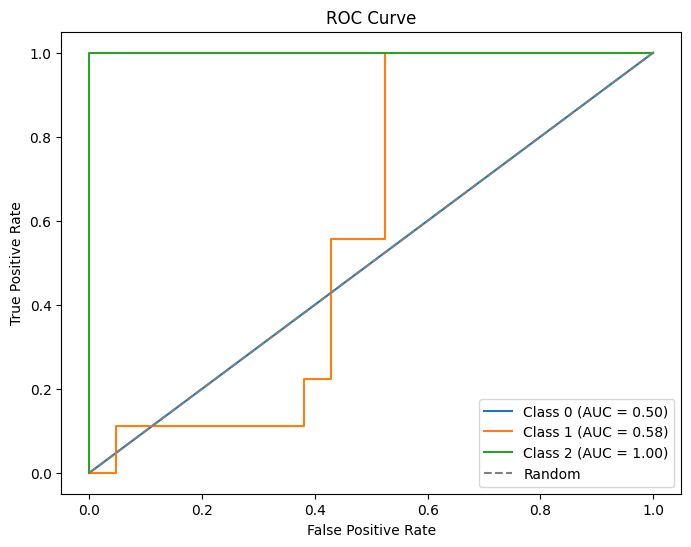

Weighted AUC: 0.69


In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Получение вероятностей принадлежности к каждому классу
model.eval()  # Установка модели в режим оценки
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_probs.extend(outputs.numpy())
        all_labels.extend(labels.numpy())

# Преобразование меток в one-hot encoding формат
all_labels_one_hot = np.eye(out_size)[all_labels]

# Рассчитываем ROC-кривую и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(out_size):
    fpr[i], tpr[i], _ = roc_curve(np.array(all_labels_one_hot)[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Средневзвешенный AUC (если у вас более двух классов)
weighted_auc = np.mean(list(roc_auc.values()))

# Визуализация ROC-кривых
plt.figure(figsize=(8, 6))

for i in range(out_size):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f'Weighted AUC: {weighted_auc:.2f}')

## Матрица неточности

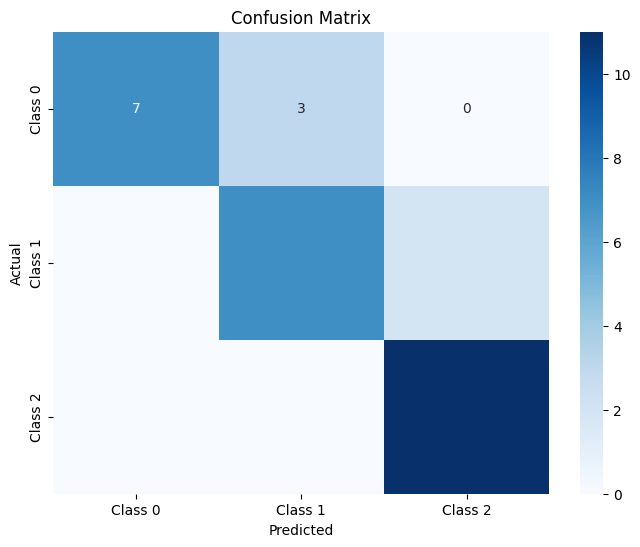

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Получение предсказаний модели на тестовом наборе данных
model.eval()
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.numpy())

# Рассчитываем матрицу неточности
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Визуализация матрицы неточности
class_names = [f'Class {i}' for i in range(out_size)]
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
